In [5]:
import numpy as np
import torch
import math

import nibabel as nib
from nibabel.testing import data_path
from nilearn import plotting
import matplotlib.pyplot as plt
from glob import glob

/home/sanketh/.local/lib/python3.5/site-packages/nilearn/__init__.py:68: FutureWarning: Python 3.5 support is deprecated and will be removed in a future release. Consider switching to Python 3.6 or 3.7
  _python_deprecation_warnings()


In [1]:
#size of patches required
block_size = (32,32,32)

#Path to the folder that contains folders of segmentation data
PATH = "../Data/Unprocessed training dataset/TrainingDataset_MSSEG/"
PATH = PATH + "*/"

In [2]:
class blocks_3d:
    def __init__(self, data, block_size = (32,32,32)):
        self.data = data
        self.block_size = block_size

    def get_data_blocks(self, ):
        x = torch.from_numpy(self.data)
        x = x.unsqueeze(0)
        kc, kh, kw = self.block_size[0], self.block_size[1], self.block_size[2]  # kernel size
        dc, dh, dw = self.block_size[0], self.block_size[1], self.block_size[2]  # stride
        patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
        unfold_shape = patches.size()
        patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
        return patches, unfold_shape

    def reconstruct(self, blocks, unfold_shape):
        
        blocks_orig = blocks.view(unfold_shape)
        output_c = unfold_shape[1] * unfold_shape[4]
        output_h = unfold_shape[2] * unfold_shape[5]
        output_w = unfold_shape[3] * unfold_shape[6]
        blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
        blocks_orig = blocks_orig.squeeze(0).detach().numpy()
        return blocks_orig

In [3]:
def zero_padding(data, block_size):
    
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]

    ceil_val = math.ceil(data.shape[1]/block_size[1])
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]

    ceil_val = math.ceil(data.shape[2]/block_size[2])
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    data = np.array(data, dtype=np.int16)
    return data

In [10]:
directory_paths = glob(PATH)
for path in directory_paths:
    flair_path = path + '3DFLAIR.nii.gz'
    seg1_path = path + 'ManualSegmentation_1.nii.gz'
    seg2_path = path + 'ManualSegmentation_2.nii.gz'
    seg3_path = path + 'ManualSegmentation_3.nii.gz'
    seg4_path = path + 'ManualSegmentation_4.nii.gz'
    seg5_path = path + 'ManualSegmentation_5.nii.gz'
    seg6_path = path + 'ManualSegmentation_6.nii.gz'
    seg7_path = path + 'ManualSegmentation_7.nii.gz'
    
    input_nifti = nib.load(flair_path)
    data = input_nifti.get_data()
    zero_padded_data = zero_padding(data, block_size)
    
    blocks_obj = blocks_3d(zero_padded_data)
    blocks, unfold_shape = blocks_obj.get_data_blocks()
    recon = blocks_obj.reconstruct(blocks, unfold_shape)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]



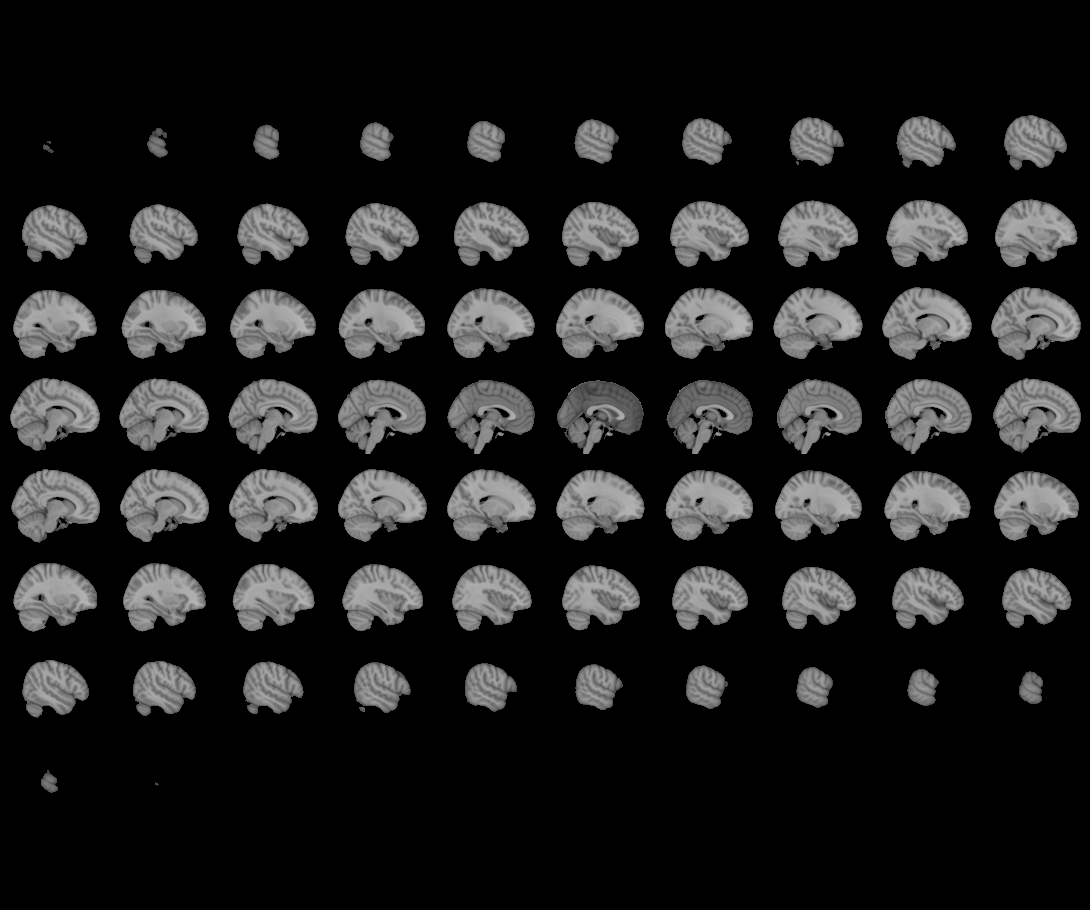
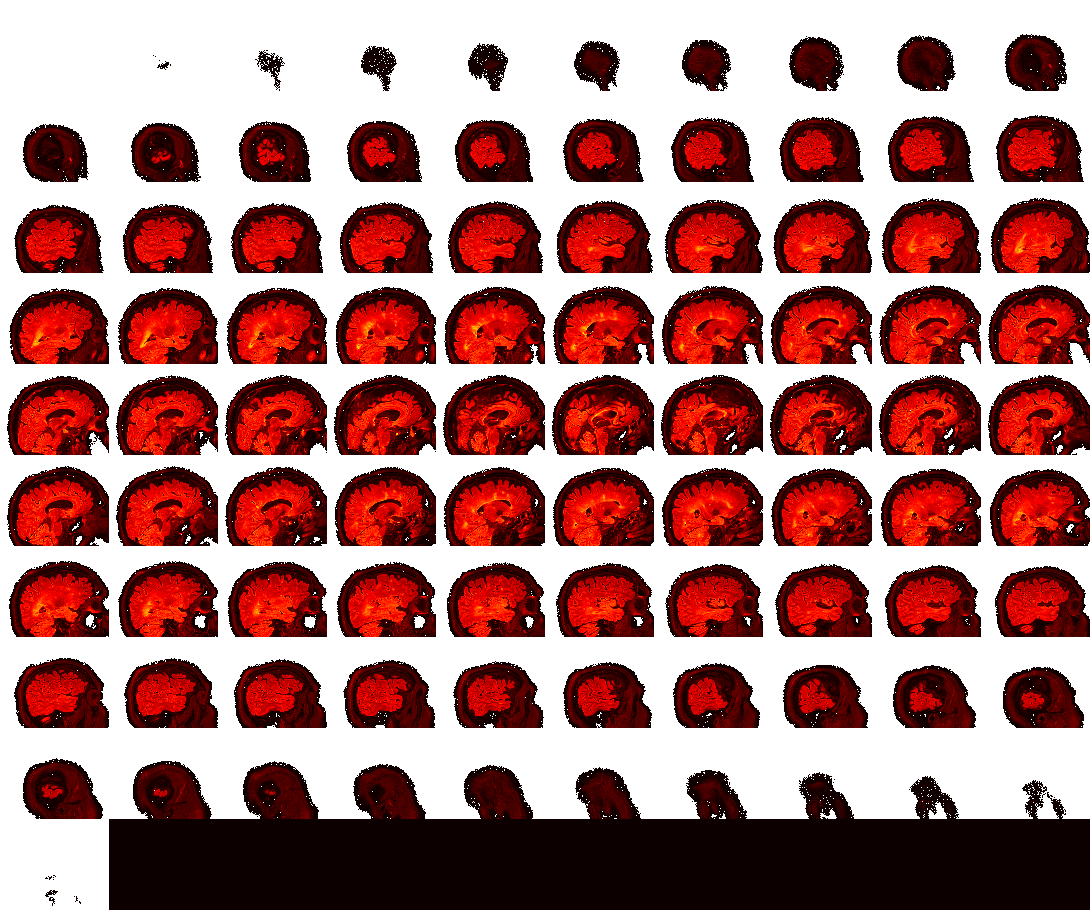

In [11]:
plotting.view_img(input_nifti)

/home/sanketh/.local/lib/python3.5/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



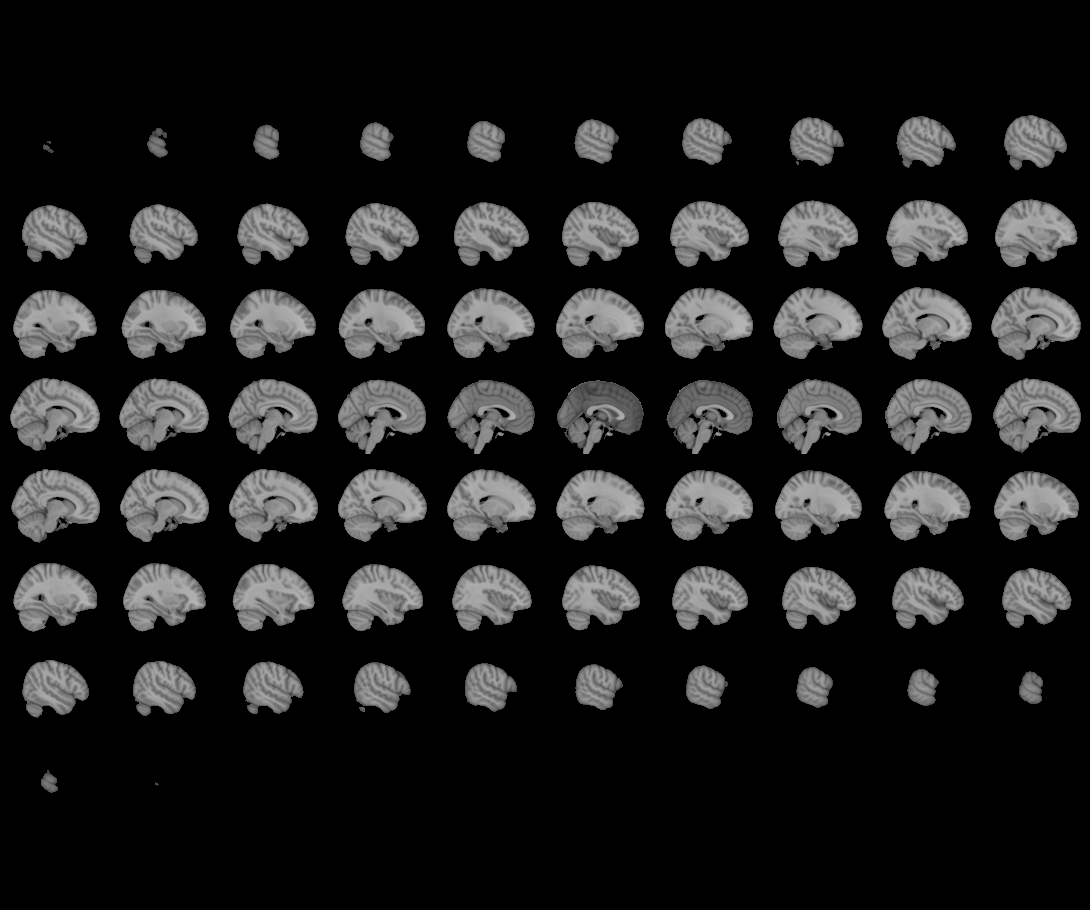
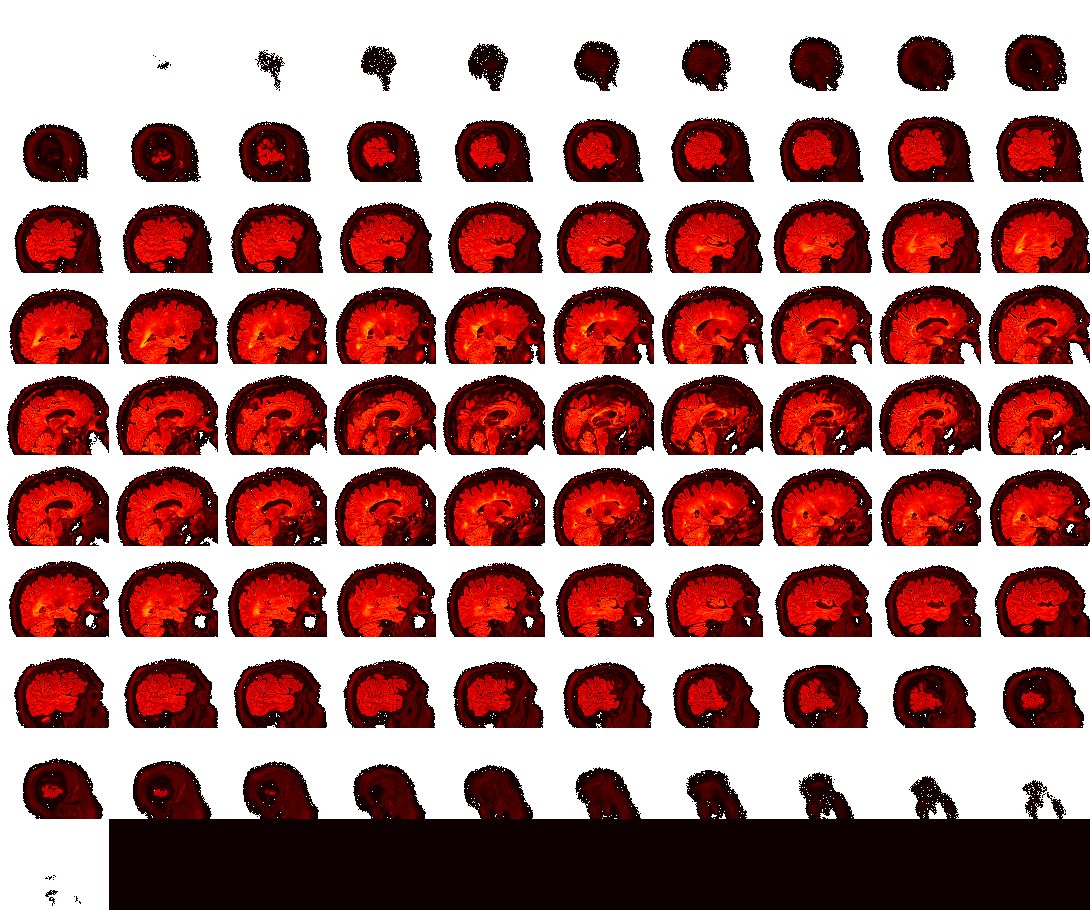

In [12]:
new_image = nib.Nifti1Image(recon, affine=input_nifti.affine)
plotting.view_img(new_image)